In [14]:
#Upload Dataset

import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

train_data = pd.read_csv('/content/drive/My Drive/S19832 Programming Assignment 02/phm_train.csv')
test_data = pd.read_csv('/content/drive/My Drive/S19832 Programming Assignment 02/phm_test.csv')

print(train_data.head())
print(test_data.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
       tweet_id  label                                              tweet
0  6.430000e+17      0  user_mention all i can tell you is i have had ...
1  6.440000e+17      0  my doctor told me stop he gave me sum pop i mi...
2  8.150000e+17      1  i take tylenol and i wake up in the middle of ...
3  6.820000e+17      0  i got xans in an advil bottle i dont take them...
4  6.440000e+17      1  mom says i need to stop eating so much bc ive ...
       tweet_id  label                                              tweet
0  6.411550e+17      0  when you try to run away from the iv needle so...
1  6.425520e+17      1  i just knew i took an ambien for sleep too ear...
2  6.410410e+17      1  i mean i get that my celexa is the reason behi...
3  7.476620e+17      0  if you call me dumb or her dumb one more time ...
4  6.406830e+17      0  i do not want to go to the grocer

In [15]:
# remove HTML, non-alphabetic characters, lowercasing, and remove stopwords.

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
english_stops = set(stopwords.words('english'))

def preprocess_tweet(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^A-Za-z]', ' ', text)
    words = [w for w in text.split() if w.lower() not in english_stops]
    words = [w.lower() for w in words]
    return words

x_train = train_data['tweet'].apply(preprocess_tweet)
y_train = train_data['label']
x_test = test_data['tweet'].apply(preprocess_tweet)
y_test = test_data['label']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
#calculate the average tweet length for padding:
import numpy as np

def get_max_length(x_data):
    review_length = [len(review) for review in x_data]
    return int(np.ceil(np.mean(review_length)))

max_length = get_max_length(x_train)


In [17]:
#convert words to integer sequences and pad them:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

token = Tokenizer(lower=False)
token.fit_on_texts(x_train)
x_train_seq = token.texts_to_sequences(x_train)
x_test_seq = token.texts_to_sequences(x_test)

x_train_pad = pad_sequences(x_train_seq, maxlen=max_length, padding='post', truncating='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1

print('Encoded X Train\n', x_train_pad, '\n')
print('Encoded X Test\n', x_test_pad, '\n')
print('Maximum review length: ', max_length)


Encoded X Train
 [[    2     1   200 ...   944  3624  1952]
 [  115   122   147 ...   193    40   322]
 [    6     3   330 ...   626  1710    29]
 ...
 [    7   529  1739 ...     0     0     0]
 [12658 12659     8 ...     0     0     0]
 [  645  1436   174 ...     0     0     0]] 

Encoded X Test
 [[  98  606  109 ...  193    4  318]
 [ 585   11   56 ...   16  707   55]
 [ 327   12 1209 ...  778    5   88]
 ...
 [   2    1  126 ...    0    0    0]
 [   2    1    3 ...    0    0    0]
 [  59    8    9 ...    0    0    0]] 

Maximum review length:  10


In [18]:
#Bi-LSTM Model

from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

EMBED_DIM = 128
LSTM_OUT = 64


model = Sequential()
model.add(Embedding(total_words, EMBED_DIM, input_length=max_length))
model.add(Bidirectional(LSTM(LSTM_OUT)))
model.add(Dense(1, activation='sigmoid'))

model.build(input_shape=(None, max_length))
print(model.summary())

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 10, 128)        │     1,620,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,719,425 (6.56 MB)

 Trainable params: 1,719,425 (6.56 MB)

 Non-trainable params: 0 (0.00 B)

None


In [19]:

checkpoint = ModelCheckpoint(
    'models/BiLSTM.h5',
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)

bilstm_history = model.fit(
    x_train_pad, y_train,
    batch_size=128,
    epochs=5,
    validation_data=(x_test_pad, y_test),
    callbacks=[checkpoint]
)

Epoch 1/5
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7215 - loss: 0.5837
Epoch 1: accuracy improved from -inf to 0.76008, saving model to models/BiLSTM.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.7224 - loss: 0.5819 - val_accuracy: 0.8190 - val_loss: 0.4016
Epoch 2/5
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8577 - loss: 0.3360
Epoch 2: accuracy improved from 0.76008 to 0.85937, saving model to models/BiLSTM.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8577 - loss: 0.3359 - val_accuracy: 0.8289 - val_loss: 0.4052
Epoch 3/5
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9057 - loss: 0.2372
Epoch 3: accuracy improved from 0.85937 to 0.90221, saving model to models/BiLSTM.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9056 - loss: 0.2373 - val_accuracy: 0.8118 - val_loss: 0.4633
Epoch 4/5
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9380 - loss: 0.1685
Epoch 4: accuracy improved from 0.90221 to 0.93284, saving model to models/BiLSTM.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.9378 - loss: 0.1687 - val_accuracy: 0.8010 - val_loss: 0.5286
Epoch 5/5
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9514 - loss: 0.1354
Epoch 5: accuracy improved from 0.93284 to 0.94655, saving model to models/BiLSTM.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9512 - loss: 0.1355 - val_accuracy: 0.7941 - val_loss: 0.6120


In [20]:
#predict on the test set and calculate accuracy
pred = model.predict(x_test_pad)
y_pred = (pred >= 0.5).astype(int).reshape(-1)

true = (y_test.values == y_pred).sum()
print('Correct Prediction:', true)
print('Wrong Prediction:', len(y_pred) - true)
print('Accuracy:', true / len(y_pred) * 100)

105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Correct Prediction: 2645
Wrong Prediction: 686
Accuracy: 79.4055839087361


Test Accuracy: 79.41%
Test Loss: 0.6120


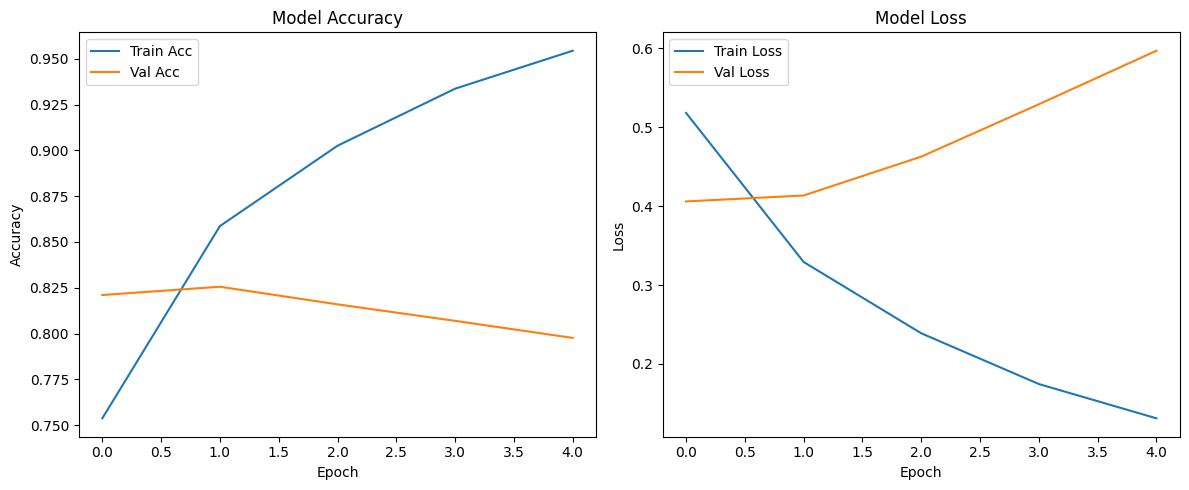

In [21]:
import matplotlib.pyplot as plt
# Use x_test_pad for evaluation, not the raw x_test
loss, accuracy = model.evaluate(x_test_pad, y_test, verbose=0)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
# Use the correct history variable (e.g., lstm_history)
plt.plot(lstm_history.history['accuracy'], label='Train Acc')
plt.plot(lstm_history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
# Use the correct history variable (e.g., lstm_history)
plt.plot(lstm_history.history['loss'], label='Train Loss')
plt.plot(lstm_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()